In [11]:
import logging, sys
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA 
from IPython.display import display, Latex

from randnn import downsample, downsample_split, avg_over
from randnn.utils import np_cache, eigsort
from randnn.plotting import *
from randnn.systems import DoubleWell
from randnn.transfer_operator import *

rc('text', usetex=True)
logging.basicConfig(level=logging.INFO)
np.set_printoptions(threshold=100)

# Applying the transfer operator approach

### 1. Coarse-graining in space:

#### Clustering

We run an explicit coarse-graining step by clustering the embedding space.

### 2. Coarse-graining in time: 

#### Downsampling
We are interested in the long-term behavior of the system (and have finitely powerful computers), so we downsample the trajectory, discarding many intermediate timesteps.

#### Delay embedding
To achieve a near-memory-less (Markovian) definition of state, we stack delayed copies of measurements within a short time window.

# Parameters

In [12]:
# ------------------------
# DOUBLE WELL PARAMETERS
# ------------------------

# Main parameters:
BETA = 1. # 2.
IS_OVERDAMPED = True

# The following parameters influence temporal resolution and trajectory duration
TIMESTEP = 0.01 # 0.01 
DOWNSAMPLE_RATE = 10 # 10

TIMESPAN = 100000 # 100000
N_STEPS = int(TIMESPAN // TIMESTEP)
N_BURNIN_STEPS = 1000 

N_CLUSTERS = 200 #1225
TRANSITION_TIMESCALE = 1 # This is the number of timesteps to take before counting a transition from one cell to the next
# -----------------------
# PLOTTING PARAMETERS
# ------------------------

EIGENVALUE_RANGE = [1, 10]

# Generating data — Overdamped

In [13]:
dw_overdamped = DoubleWell(beta=BETA, timestep=TIMESTEP, is_overdamped=True)
ts_overdamped = dw_overdamped.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)[::DOWNSAMPLE_RATE]

INFO:root:Loading from save ./saves/trajectories/trajectory-5914cf1912fc76edb06ec6f5e932cd2a.npy


## Equilibrium

Let's establish that we've actually settled into equilibrium. 

### Boltzmann distribution

The first check is that the Boltzmann distributions appear qualitatively similar. If this is off, we already know we need to go back to the drawing board.


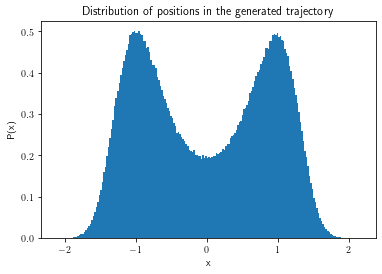

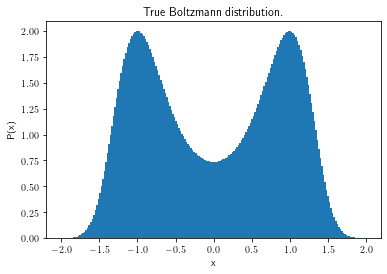

In [14]:
dX = 0.01
positions = np.array([np.arange(-2, 2, dX)]).T

# We compare the observed Boltzmann distribution...

plt.hist(ts_overdamped, density=True, bins=N_CLUSTERS)
plt.ylabel("P(x)")
plt.xlabel("x")

plt.title("Distribution of positions in the generated trajectory")
plt.show()

# ...against the theoretical distribution

weights = dw_overdamped.boltzmann_weights(positions)
plt.hist(positions, weights=weights, bins=N_CLUSTERS)
plt.ylabel("P(x)")
plt.xlabel("x")

plt.title("True Boltzmann distribution.")
plt.show()

### Energy distribution

For a more quantitative check, we can compare the observed energy distribution to the theoretical distribution and confirm that the equipartition theorem holds (i.e. that each dof has, on average, an energy $kT/2$). 

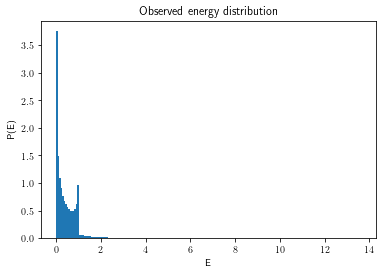

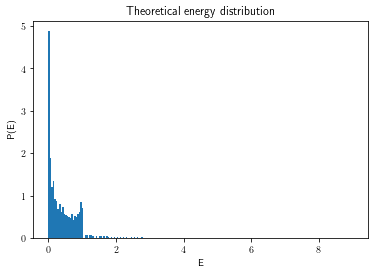

The average energy of the particle is 0.4324010239135469
The theoretical energy is (as given by the equipartition theorem):


<IPython.core.display.Latex object>

In [15]:
# We compare the observed energy distribution...
energies = dw_overdamped.energy(ts_overdamped)
plt.title("Observed energy distribution")
plt.hist(energies, density=True, bins=N_CLUSTERS)
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

# ... against the theoretical distribution.

theoretical_energies = dw_overdamped.energy(positions) 
plt.title("Theoretical energy distribution")
plt.hist(theoretical_energies, density=True, bins=N_CLUSTERS, weights=weights)
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

# And compare the average energy.
print(f"The average energy of the particle is {np.mean(energies)}")
print("The theoretical energy is (as given by the equipartition theorem):")
display(Latex(f"$kT/2 = {1./(2* BETA)}$"))

### Convergence

We make sure we've included enough burn in samples and that the running average energy isn't fluctuating too wildly.

In [16]:
"""
running_avg_energy = dw_overdamped.running_avg(
    ts_overdamped, 
    dw_overdamped.energy,
    window_size=10000,
    step_size=1000,
    verbose=True
)

plt.plot(running_avg_energy)
"""

'\nrunning_avg_energy = dw_overdamped.running_avg(\n    ts_overdamped, \n    dw_overdamped.energy,\n    window_size=10000,\n    step_size=1000,\n    verbose=True\n)\n\nplt.plot(running_avg_energy)\n'

# Testing Transfer matrix – Overdamped case

In [17]:
to_overdamped = TransferOperator(labeling_method="uniform", n_clusters=100)
to_overdamped.fit(verbose=True, time_series=ts_overdamped, n_future_timesteps=TRANSITION_TIMESCALE, k=50)
tm_overdamped = to_overdamped.forward_matrix

## Equilibrium

Let's establish that we've actually settled into equilibrium. 

### Boltzmann distribution

The first check is that the Boltzmann distributions appear qualitatively similar. If this is off, we already know we need to go back to the drawing board.


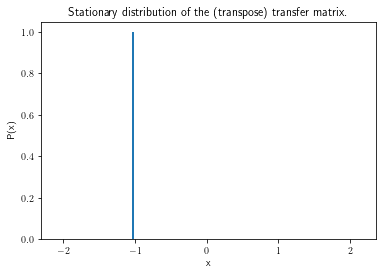

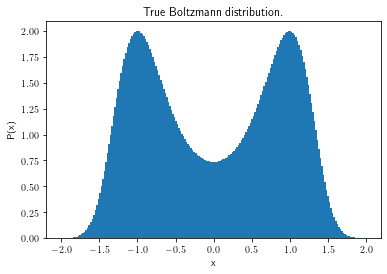

In [18]:
cluster_centers = to_overdamped.cluster_centers
eigvals, eigvecs = eigsort(to_overdamped.reverse_matrix.T, eig_method="np")

dX = 0.01
positions = np.array([np.arange(-2, 2, dX)]).T


# We compare the observed energy distribution...

stable_dist = np.abs(eigvecs[:,0])
min_x = np.amin(ts_overdamped, axis=0)
max_x = np.amax(ts_overdamped, axis=0)
step = (max_x-min_x) / stable_dist.size

plt.hist(cluster_centers, weights=stable_dist, bins=N_CLUSTERS)
plt.ylabel("P(x)")
plt.xlabel("x")
plt.title("Stationary distribution of the (transpose) transfer matrix.")
plt.show()

# ...against the theoretical distribution

weights = dw_overdamped.boltzmann_weights(positions)
plt.hist(positions, weights=weights, bins=N_CLUSTERS)
plt.ylabel("P(x)")
plt.xlabel("x")

plt.title("True Boltzmann distribution.")
plt.show()

### Energy distribution

For a more quantitative check, we can compare the observed energy distribution to the theoretical distribution and confirm that the equipartition theorem holds (i.e. that each dof has, on average, an energy $kT/2$). 

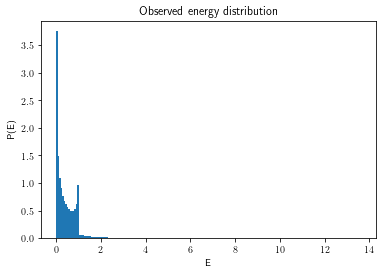

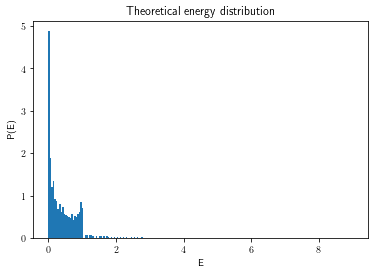

The average energy of the particle is 0.4324010239135469
The theoretical energy is (as given by the equipartition theorem):


<IPython.core.display.Latex object>

In [19]:
# We compare the observed energy distribution...
energies = dw_overdamped.energy(ts_overdamped)
plt.title("Observed energy distribution")
plt.hist(energies, density=True, bins=N_CLUSTERS)
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

# ... against the theoretical distribution.

theoretical_energies = dw_overdamped.energy(positions) 
plt.title("Theoretical energy distribution")
plt.hist(theoretical_energies, density=True, bins=N_CLUSTERS, weights=weights)
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

# And compare the average energy.
print(f"The average energy of the particle is {np.mean(energies)}")
print("The theoretical energy is (as given by the equipartition theorem):")
display(Latex(f"$kT/2 = {1./(2* BETA)}$"))

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


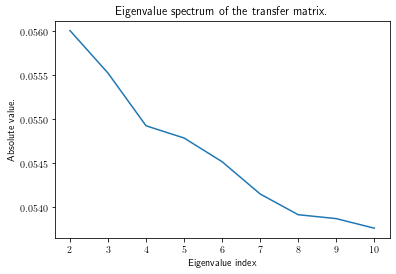

In [20]:
plot_eig_spectrum(eigvals, EIGENVALUE_RANGE, "Eigenvalue spectrum of the transfer matrix.")

### Detailed balance

Finally, we require that detailed balance holds, i.e.: 
$$\pi_i P_{ij} = \pi_j P_{ji},$$ 
where $P$ is the transition matrix and $\pi$ is the stationary distribution.